In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import sys
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
%cd /content/gdrive/MyDrive/MTL-RED/

/content/gdrive/MyDrive/MTL-RED


In [ ]:
import sys
import io
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Define a Tee class that writes to both console and log file

class Tee:
    def __init__(self, file_path):
        self.file = open(file_path, "a")  # Open in append mode (real-time updates)
        self.stdout = sys.__stdout__  # Store reference to original console output

    def write(self, message):
        self.stdout.write(message)  # Print to console immediately
        self.file.write(message)  # Write to file
        self.stdout.flush()  # Ensure console updates immediately
        self.file.flush()  # Ensure log file updates immediately

    def flush(self):
        self.stdout.flush()
        self.file.flush()

    def close(self):
        self.file.close()





# # Initialize the log file for capturing all output
# log_filename = "hyperparam_search_output.log"
# tee = Tee(log_filename)  # Create a Tee instance


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
benign = pd.read_csv("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_1.csv") #BENIGN_TEST
benign = benign.dropna()
benign.to_csv('/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_LAST_1.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np

def load_csv(path, label_val):
    """
    Loads a CSV file and assigns the correct label.
    Ensures that the 'Label' column is correctly set (0 for benign, 1 for attack).
    """
    df = pd.read_csv(path)

    # Ensure all labels are correctly assigned
    df['Label'] = label_val
    return df

def add_noise(df, epsilon=1e-6):
    """
    Adds small Gaussian noise to all numerical columns except 'Label'.
    Helps prevent numerical stability issues in Mutual Information calculations.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns  # Find numerical columns
    numeric_cols = numeric_cols.drop("Label", errors="ignore")  # Exclude the 'Label' column

    noise = np.random.randn(*df[numeric_cols].shape) * epsilon
    df[numeric_cols] += noise  # Apply noise only to selected columns

    return df

# File paths for training and OOD datasets
datasets = {
    "benign_train": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_LAST_1.csv", 0),
    "attack1": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SOLARIS.csv", 1),
    "attack2": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_INFIL.csv", 1),
    "attack3": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_OOD_BOT.csv", 1),
    "attack4": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_GOLDEN_EYE.csv", 1),
    "benign_val": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_TEST.csv", 0),
    "attack_ood4": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_RARE.csv", 1),
    "attack_ood5": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SlowHTTPTest.csv", 1),
    "attack_ood6": ("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_HOIC.csv", 1),
}

# Load and preprocess each dataset
processed_datasets = {}
for name, (path, label) in datasets.items():
    df = load_csv(path, label)

    # Add small noise to numerical features (except "Label")
    df = add_noise(df)

    # Save the processed dataset with "_FIXED.csv" suffix
    save_path = path.replace(".csv", "_FIXED.csv")
    df.to_csv(save_path, index=False)

    # Store in dictionary for later use
    processed_datasets[name] = df

    # Print status
    print(f"✅ Processed & saved {name}: {save_path}")


✅ Processed & saved benign_train: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_LAST_1_FIXED.csv
✅ Processed & saved attack1: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SOLARIS_FIXED.csv
✅ Processed & saved attack2: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_INFIL_FIXED.csv
✅ Processed & saved attack3: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_OOD_BOT_FIXED.csv
✅ Processed & saved attack4: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_GOLDEN_EYE_FIXED.csv
✅ Processed & saved benign_val: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_TEST_FIXED.csv
✅ Processed & saved attack_ood4: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_RARE_FIXED.csv
✅ Processed & saved attack_ood5: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SlowHTTPTest_FIXED.csv
✅ Processed & saved attack_ood6: /content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_HOIC_FIXED.csv


In [ ]:
#botnet = pd.read_csv("/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_OOD_BOT.csv")

In [ ]:
# File paths for CSV files (adjust paths as needed)
benign_path_train   = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_LAST_1_FIXED.csv"
attack_path1  = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SOLARIS_FIXED.csv"
attack_path2  = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_INFIL_FIXED.csv"
attack_path3  = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_OOD_BOT_FIXED.csv"
attack_path4  = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_GOLDEN_EYE_FIXED.csv"

# Load CSVs into DataFrames (optionally subsample for quicker experiments)
# Validation data uses one benign file + an OOD attack dataset
benign_val_path  = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_TEST_FIXED.csv"
attack_ood_path4 = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_RARE_FIXED.csv"
attack_ood_path5 = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SlowHTTPTest_FIXED.csv"
attack_ood_path6 = "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_HOIC_FIXED.csv"

In [ ]:
# Take just features
import pandas as pd

# Define file paths
file_paths = {
    "attack_path1": "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SOLARIS_FIXED.csv",
    "attack_path2": "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_INFIL_FIXED.csv",
    "attack_path3": "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_OOD_BOT_FIXED.csv",
    "attack_path4" : "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_GOLDEN_EYE_FIXED.csv",
    "benign_val_path": "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/BENIGN_TEST_FIXED.csv",
    "attack_ood_path4": "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_RARE_FIXED.csv",
    "attack_ood_path5": "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_SlowHTTPTest_FIXED.csv",
    "attack_ood_path6": "/content/gdrive/MyDrive/MTL-RED/DATA/CSE_CIC_IDS/TRAIN/TEST_HOIC_FIXED.csv"
}

# Load datasets while ignoring the "Label" column
datasets = {name: pd.read_csv(path, usecols=lambda column: column != "Label") for name, path in file_paths.items()}

# Access individual datasets like this:
attack_path1 = datasets["attack_path1"]
attack_path2 = datasets["attack_path2"]
attack_path3 = datasets["attack_path3"]
attack_path4 = datasets["attack_path4"]
benign_val_path = datasets["benign_val_path"]
attack_ood_path4 = datasets["attack_ood_path4"]
attack_ood_path5 = datasets["attack_ood_path5"]
attack_ood_path6 = datasets["attack_ood_path6"]
# Concatenate the datasets
attack_path33 = pd.concat([attack_path2, attack_path3], ignore_index=True)

# Display first few rows of one dataset to verify
#attack_path33.head()


In [ ]:
import numpy as np

def compare_correlation_norm(X, Y, use_covariance=False):
    """
    Computes the Frobenius norm of the difference between the correlation
    matrices (or covariance matrices) of datasets X and Y.

    Parameters:
        X (np.ndarray): Data matrix of shape (N, d).
        Y (np.ndarray): Data matrix of shape (N, d).
        use_covariance (bool): If True, use the covariance matrices instead
                               of correlation matrices.

    Returns:
        float: The Frobenius norm of the difference between the two matrices.
    """
    if use_covariance:
        # Compute covariance matrices; rowvar=False means each column is a feature
        M1 = np.cov(X, rowvar=False)
        M2 = np.cov(Y, rowvar=False)
    else:
        # Compute correlation matrices using np.corrcoef on transposed data
        # Note: np.corrcoef expects variables in rows.
        M1 = np.corrcoef(X, rowvar=False)
        M2 = np.corrcoef(Y, rowvar=False)

    diff = M1 - M2
    fro_norm = np.linalg.norm(diff, ord='fro')
    return fro_norm

def check_covariance_ratio(X, Y, kappa):
    """
    Checks if the covariance matrix of Y is bounded above by kappa times the covariance
    matrix of X in the positive semidefinite sense. In practice, we compute the generalized
    eigenvalues of (cov_Y, cov_X) and return the maximum eigenvalue.

    Parameters:
        X (np.ndarray): Data matrix of shape (N, d) from distribution P.
        Y (np.ndarray): Data matrix of shape (N, d) from distribution Q.
        kappa (float): A threshold scalar.

    Returns:
        max_eig (float): The maximum generalized eigenvalue (largest λ such that
                         cov_Y v = λ cov_X v). If max_eig <= kappa, then in all directions,
                         the variance under Q is bounded by kappa times that under P.
        eigvals (np.ndarray): All generalized eigenvalues.
    """
    # Compute sample covariance matrices
    cov_X = np.cov(X, rowvar=False)
    cov_Y = np.cov(Y, rowvar=False)

    # To avoid numerical issues, add a small diagonal regularization if needed:
    eps = 1e-6
    cov_X += eps * np.eye(cov_X.shape[0])

    # Solve the generalized eigenvalue problem: cov_Y v = λ cov_X v.
    # This can be done by computing the eigenvalues of inv(cov_X)*cov_Y.
    inv_cov_X = np.linalg.inv(cov_X)
    A = inv_cov_X @ cov_Y
    eigvals = np.linalg.eigvals(A)
    # In theory, all eigenvalues should be real for PSD matrices; take the real part.
    eigvals = np.real(eigvals)
    max_eig = np.max(eigvals)
    return max_eig, eigvals

# Example usage:
if __name__ == "__main__":
    # Generate some synthetic data for two datasets:
    np.random.seed(0)
    N, d = attack_path1.shape[0], attack_path1.shape[1]

    # Let dataset1 be drawn from a standard normal:
    X = attack_path1 #attack_path33

    # Dataset2: same marginals, but add a twist to the correlation:
    # For example, apply a random rotation matrix.
    #random_rotation = np.linalg.qr(np.random.randn(d, d))[0]  # QR gives an orthonormal matrix
    Y = attack_ood_path4

    # Now check the difference between correlation matrices:
    corr_norm = compare_correlation_norm(X, Y, use_covariance=False)
    print("Frobenius norm between correlation matrices:", corr_norm)

    # Also check using covariance matrices:
    cov_norm = compare_correlation_norm(X, Y, use_covariance=True)
    print("Frobenius norm between covariance matrices:", cov_norm)

    # Now check the covariance ratio: Does cov(Y) <= kappa * cov(X)?
    kappa = 1.5  # example threshold
    max_eig, eigvals = check_covariance_ratio(X, Y, kappa)
    print("Maximum generalized eigenvalue:", max_eig)
    print("All generalized eigenvalues:", eigvals)
    if max_eig <= kappa:
        print("The covariance of Y is bounded above by kappa times the covariance of X.")
    else:
        print("The covariance of Y is not bounded by kappa times the covariance of X.")

#3494986.4216504917
#1485109.7282531168

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

In [ ]:
def marginal_coverage_ratio(X, Y, eps=1e-12):
    """
    Computes a coverage ratio for each dimension between two datasets X and Y.
    For dimension i, define:
        overlap_range_i = intersection of the [min, max] intervals of X_i and Y_i
        union_range_i   = union of those intervals
        coverage_i = overlap_range_i / union_range_i

    Returns:
        coverage_ratios (1D array of length d)
    """
    # X and Y shape: (N, d)
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    Y_min = np.min(Y, axis=0)
    Y_max = np.max(Y, axis=0)

    # For each dimension i:
    coverage_ratios = []
    for i in range(X.shape[1]):
        # Overlap
        overlap_min = max(X_min[i], Y_min[i])
        overlap_max = min(X_max[i], Y_max[i])
        overlap_range = max(0.0, overlap_max - overlap_min)

        # Union
        union_min = min(X_min[i], Y_min[i])
        union_max = max(X_max[i], Y_max[i])
        union_range = max(eps, union_max - union_min)

        coverage_i = overlap_range / union_range
        coverage_ratios.append(coverage_i)

    return np.array(coverage_ratios)


In [ ]:
def compute_correlation_matrix(X):
    """
    Returns the d x d correlation matrix of dataset X (N x d).
    """
    return np.corrcoef(X, rowvar=False)

def compute_covariance_matrix(X):
    """
    Returns the d x d covariance matrix of dataset X (N x d).
    """
    return np.cov(X, rowvar=False)


In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, leaves_list

def reorder_features_by_clustering(corr_matrix, method='average'):
    """
    Perform hierarchical clustering on the correlation matrix and
    return a permutation of feature indices that groups correlated features together.
    """
    # Convert correlation to distance
    dist_matrix = 1.0 - corr_matrix

    # Distances must be condensed for scipy's linkage if we use leaves_list
    # So we flatten the upper triangle:
    # The correlation matrix is d x d, we get the condensed distance vector
    dists_condensed = squareform(dist_matrix, checks=False)

    # Perform hierarchical clustering
    linkage_mat = linkage(dists_condensed, method=method)

    # leaves_list gives the ordering of the features
    feature_order = leaves_list(linkage_mat)
    return feature_order


In [ ]:
def measure_block_diagonal(corr_matrix, feature_order, block_size=2):
    """
    A toy measure: partition the permuted matrix into blocks of 'block_size'
    and see how large the off-block values are.

    For a real scenario, you'd define a more robust measure:
    - e.g., find the sum of absolute correlation in off-diagonal blocks
      vs. the diagonal blocks.
    """
    d = corr_matrix.shape[0]
    perm_corr = corr_matrix[np.ix_(feature_order, feature_order)]

    # We'll just sum the absolute correlation in off-block areas
    # For demonstration, assume you define blocks of size=block_size
    # and see if the matrix is "close" to block diagonal
    sum_off_block = 0.0
    sum_total = 0.0
    for i in range(d):
        for j in range(d):
            val = abs(perm_corr[i, j])
            sum_total += val
            # If i and j belong to different blocks
            block_i = i // block_size
            block_j = j // block_size
            if block_i != block_j:
                sum_off_block += val

    # ratio of off-block to total
    ratio = sum_off_block / (sum_total + 1e-12)
    return ratio, perm_corr


In [ ]:
attack_ood_path6.shape

(10000, 30)

In [ ]:
def clusterability_test(X):
    corr = compute_correlation_matrix(X)
    feature_order = reorder_features_by_clustering(corr, method='average')
    ratio, perm_corr = measure_block_diagonal(corr, feature_order, block_size=4)  # e.g. block_size=4
    return ratio, corr, perm_corr, feature_order


def main():
    # A, B, C are your real datasets, shape (N, d)
    # 1) Coverage
    print("Coverage: A vs B:", marginal_coverage_ratio(attack_ood_path4, attack_ood_path5).mean())
    print("Coverage: A vs C:", marginal_coverage_ratio(attack_ood_path4, attack_path1).mean())
    print("Coverage: B vs C:", marginal_coverage_ratio(attack_ood_path5, attack_path1).mean())

    # 2) Clusterability
    ratioA, corrA, perm_corrA, orderA = clusterability_test(attack_ood_path4)
    ratioB, corrB, perm_corrB, orderB = clusterability_test(attack_path1)
    ratioC, corrC, perm_corrC, orderC = clusterability_test(attack_ood_path5)

    print(f"A block-diagonal ratio: {ratioA:.3f}")
    print(f"B block-diagonal ratio: {ratioB:.3f}")
    print(f"C block-diagonal ratio: {ratioC:.3f}")

    # If ratio is near zero, the correlation matrix is close to block-diagonal after reordering
    # If ratio is near 1, it is definitely not block diagonal.

    # Optionally, you can visualize
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    # Original correlation
    sns.heatmap(corrA, ax=axes[0,0], cmap='RdBu_r', center=0)
    axes[0,0].set_title("A original corr")
    sns.heatmap(corrB, ax=axes[0,1], cmap='RdBu_r', center=0)
    axes[0,1].set_title("B original corr")
    sns.heatmap(corrC, ax=axes[0,2], cmap='RdBu_r', center=0)
    axes[0,2].set_title("C original corr")

    # Reordered correlation
    sns.heatmap(perm_corrA, ax=axes[1,0], cmap='RdBu_r', center=0)
    axes[1,0].set_title("A reordered corr")
    sns.heatmap(perm_corrB, ax=axes[1,1], cmap='RdBu_r', center=0)
    axes[1,1].set_title("B reordered corr")
    sns.heatmap(perm_corrC, ax=axes[1,2], cmap='RdBu_r', center=0)
    axes[1,2].set_title("C reordered corr")

    plt.tight_layout()
    plt.show()


<ipython-input-24-c549b410dee6>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overlap_min = max(X_min[i], Y_min[i])
<ipython-input-24-c549b410dee6>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overlap_max = min(X_max[i], Y_max[i])
<ipython-input-24-c549b410dee6>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  union_min = min(X_min[i], Y_min[i])
<ipython-input-24-c549b410dee6>:28: FutureWarning: Series.__getitem__ treating

Coverage: A vs B: 0.23614800414703724
Coverage: A vs C: 0.4238385075037357
Coverage: B vs C: 0.27507917674376264
A block-diagonal ratio: 0.739
B block-diagonal ratio: 0.719
C block-diagonal ratio: 0.783


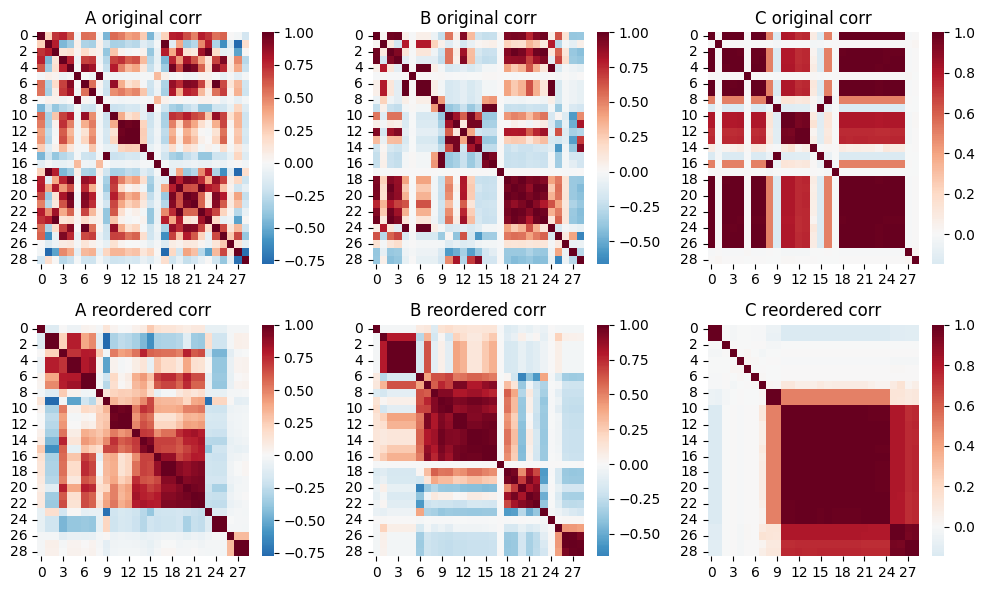

In [ ]:
# 4) Actually call main()
if __name__ == "__main__":
    main()

In [ ]:
def load_csv(path, label_val):
    """
    Loads a CSV file and filters rows by label.
    Assumes the CSV has a 'Label' column.
    """
    df = pd.read_csv(path)
    # Filter for desired label (0 for benign, 1 for attack)
    df = df[df['Label'] == label_val]
    return df

In [ ]:
# Load data (adjust row slicing if needed)
benign_cic       = load_csv(benign_path_train, 0).iloc[:50000]
attack_df1      = load_csv(attack_path1, 1).iloc[:10000]
attack_df2      = load_csv(attack_path2, 1).iloc[:10000]
attack_df3      = load_csv(attack_path3, 1).iloc[:10000]
attack_df4      = load_csv(attack_path4, 1).iloc[:10000]

benign_val_df   = load_csv(benign_val_path, 0).iloc[:10000]     # validation benign
attack_ood_df4  = load_csv(attack_ood_path4, 1).iloc[:500]    # OOD dataset 4
attack_ood_df5  = load_csv(attack_ood_path5, 1).iloc[:10000]    # OOD dataset 5
attack_ood_df6  = load_csv(attack_ood_path6, 1).iloc[:10000]    # OOD dataset 6

In [ ]:
def make_ood_data_gaussian_noise(df, severity=0.1, random_seed=42):
    """
    Adds Gaussian noise to numeric columns of the DataFrame, making the dataset
    more distinct (simulating an OOD shift), while **excluding the 'Label' column**.

    Parameters:
    - df (DataFrame): Original dataset.
    - severity (float): Scale of the noise. 0.1 means mild noise, 1.0 means heavy noise.
    - random_seed (int): Fix seed for reproducibility.

    Returns:
    - new_df (DataFrame): A copy of df with injected noise (excluding 'Label').
    """
    new_df = df.copy(deep=True)

    np.random.seed(random_seed)

    # Identify numeric columns excluding 'Label'
    numeric_cols = [col for col in new_df.select_dtypes(include=[np.number]).columns if col != "Label"]

    for col in numeric_cols:
        # For each numeric column, add Gaussian noise ~ N(0, severity * std_dev)
        std_dev = new_df[col].std() or 1e-6  # Avoid zero std dev
        noise = np.random.normal(0, severity * std_dev, size=len(new_df))
        new_df[col] += noise  # Add noise in place

    return new_df

In [ ]:
def make_ood_data_transforms(df, shift_scale=0.2, reorder=False, random_seed=42):
    """
    Applies random scaling & shifting to numeric columns, optionally reorders columns,
    making the dataset more OOD-like, while **excluding the 'Label' column**.

    Parameters:
    - df (DataFrame): Original dataset.
    - shift_scale (float): Magnitude for random shifts and scales.
    - reorder (bool): If True, randomizes column ordering.
    - random_seed (int): Fix seed for reproducibility.

    Returns:
    - new_df (DataFrame): Transformed dataset (excluding 'Label' from modifications).
    """
    new_df = df.copy(deep=True)
    np.random.seed(random_seed)

    # Identify numeric columns excluding 'Label'
    numeric_cols = [col for col in new_df.select_dtypes(include=[np.number]).columns if col != "Label"]

    for col in numeric_cols:
        # Random scale factor ~ Uniform(1-shift_scale, 1+shift_scale)
        scale_factor = 1.0 + (2 * shift_scale * np.random.rand() - shift_scale)
        # Random shift ~ Uniform(-shift_scale, +shift_scale) * col std dev
        std_dev = new_df[col].std() or 1e-6
        shift = (2 * shift_scale * np.random.rand() - shift_scale) * std_dev

        # Apply scale & shift
        new_df[col] = new_df[col] * scale_factor + shift

    if reorder:
        # Randomly permute columns (excluding "Label" column)
        cols = [col for col in new_df.columns if col != "Label"]
        np.random.shuffle(cols)
        new_df = new_df[cols + ["Label"]]  # Keep "Label" as the last column

    return new_df


In [ ]:
benign_val_df_ood = benign_cic
attack_df3_ood = attack_df3
attack_df4_ood = attack_df4
attack_ood_df4_ood = attack_ood_df4
attack_ood_df5_ood = attack_ood_df5
attack_ood_df6_ood = attack_ood_df6

# 3) Use these 'augmented' OOD datasets in your pipeline
test_datasets = {
    "RARE": attack_ood_df4_ood,
    "SLOWHTTPS": attack_ood_df5_ood,
    "HOIC": attack_ood_df6,
    # etc.
}

In [ ]:
import random
import numpy as np
import pandas as pd

def create_segmented_dataset(
    base_df,
    other_dfs,         # Dict of attack datasets, e.g. { "SOLARIS": df_solaris, ... }
    segment_sizes,     # Dict specifying segment size for each attack dataset
    segment_counts,    # Dict specifying number of insertions for each attack dataset
    test_set=False,
    rare_class=False,  # If True, handle the entire chunk for 'RARE' dataset
    random_seed=42
):
    """
    Creates a dataset by:
      - Using base_df as benign dataset.
      - Splitting attack datasets into **70% train, 30% test**.
      - Inserts attack segments into base_df at **random positions**.
      - Allows **different segment sizes & number of insertions** for training and test.

    Parameters:
    - base_df (DataFrame): Benign dataset.
    - other_dfs (dict): Dict of attack datasets `{ "SOLARIS": df_solaris, ... }`.
    - segment_sizes (dict): Dict of segment sizes for each attack dataset.
    - segment_counts (dict): Dict of number of insertions for each attack dataset.
    - test_set (bool): If True, inserts attack samples from the **30% test split**.
    - rare_class (bool): If True, takes the entire attack dataset.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - final_df (DataFrame): The benign dataset with attack segments inserted.
    """

    random.seed(random_seed)
    np.random.seed(random_seed)

    # ✅ Keep base dataset unchanged
    base_portion = base_df.copy(deep=True)
    final_df = base_portion.copy(deep=True)

    # ✅ Helper: Insert a block at a random position in final_df
    def insert_block_at_random(main_df, block_df):
        if len(main_df) == 0:
            return block_df.reset_index(drop=True)
        pos = random.randint(0, len(main_df))
        top = main_df.iloc[:pos]
        bottom = main_df.iloc[pos:]
        merged = pd.concat([top, block_df, bottom], ignore_index=True)
        return merged.reset_index(drop=True)

    # ✅ Iterate through each attack dataset and insert segments
    for name, attack_df in other_dfs.items():
        # ✅ 70:30 split for attack dataset
        att_split = int(len(attack_df) * 0.70)
        att_train = attack_df.iloc[:att_split]
        att_test = attack_df.iloc[att_split:]

        # ✅ Choose train or test portion
        chunk_df = att_test if test_set else att_train

        if len(chunk_df) == 0:
            print(f"⚠ Warning: Attack dataset '{name}' has NO samples in {'TEST' if test_set else 'TRAIN'} set.")
            continue

        if test_set and rare_class:
            # ✅ RARE case: Take **entire** dataset and insert once
            block_size_local = len(chunk_df)
            final_df = insert_block_at_random(final_df, chunk_df)
            print(f"[create_segmented_dataset] Inserted ENTIRE RARE chunk of size {block_size_local}.")

        else:
            # ✅ Insert multiple segments at random positions
            segment_size = segment_sizes.get(name, 100)  # Default to 100 if not specified
            segment_count = segment_counts.get(name, 1)  # Default to 1 if not specified

            for _ in range(segment_count):
                block_size_local = min(segment_size, len(chunk_df))
                if block_size_local <= 0:
                    continue

                # ✅ Random start position
                start_pos = random.randint(0, max(0, len(chunk_df) - block_size_local))
                segment_block = chunk_df.iloc[start_pos : start_pos + block_size_local]

                final_df = insert_block_at_random(final_df, segment_block)

        print(f"[create_segmented_dataset] Inserted '{name}' (test_set={test_set}, rare={rare_class}).")

    # ✅ Ensure **benign samples match attack samples in TEST SET**
    if test_set:
        attack_count = len(final_df) - len(base_portion)
        benign_test_subset = base_df.sample(n=attack_count, replace=False, random_state=42)
        final_df = pd.concat([final_df, benign_test_subset], ignore_index=True)

    print(f"[create_segmented_dataset] Final {'TEST' if test_set else 'TRAIN'} shape: {final_df.shape}")

    return final_df.reset_index(drop=True)


In [ ]:
#############################################
# 2. Custom Dataset that Converts CSV DataFrames Directly to Tensors
#############################################

class CSVCustomDataset(Dataset):
    def __init__(self, df):
        # Convert numeric columns to float32 for consistency.
        numeric_cols = df.select_dtypes(include=['float64', 'float32']).columns
        df[numeric_cols] = df[numeric_cols].astype(np.float32)
        # Convert features and labels to tensors.
        self.x = torch.tensor(df.loc[:, df.columns != 'Label'].values, dtype=torch.float32)
        self.y = torch.tensor(df['Label'].values, dtype=torch.long)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.x.size(0)

In [ ]:
import torch
import torch.nn as nn

class MultitaskAutoencoder(nn.Module):
    def __init__(self, D_in, H=20, H2=10, latent_dim=5, dropout_prob=0.3):
        super(MultitaskAutoencoder, self).__init__()

        # Encoder
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, latent_dim)
        self.dropout = nn.Dropout(p=dropout_prob)

        self.classifier = nn.Linear(latent_dim, 2)  # Binary classifier

        # Decoder
        self.fc3 = nn.Linear(latent_dim, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        self.fc4 = nn.Linear(H2, H)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H)
        self.fc5 = nn.Linear(H, D_in)

        self.activation = nn.LeakyReLU(negative_slope=0.02)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def encode(self, x):
        x = self.activation(self.lin_bn1(self.linear1(x)))
        x = self.dropout(x)
        x = self.activation(self.lin_bn2(self.linear2(x)))
        x = self.dropout(x)
        return self.linear3(x)  # No activation in latent space

    def decode(self, z):
        z = self.activation(self.lin_bn3(self.fc3(z)))
        z = self.dropout(z)
        z = self.activation(self.lin_bn4(self.fc4(z)))
        return self.fc5(z)  # No activation in the output

    def forward(self, inputs):
        z = self.encode(inputs)
        logits = self.classifier(z)
        reconstruction = self.decode(z)
        return logits, reconstruction, z


In [ ]:
import torch
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()

    def calculate_gram_mat(self, X, sigma):
        x2 = torch.sum(X * X, dim=1, keepdim=True)
        dist = -2.0 * (X @ X.t()) + x2 + x2.t()
        gram = torch.exp(-dist / sigma)
        return gram

    def renyi_entropy(self, X, sigma, alpha=2.0):
        K = self.calculate_gram_mat(X, sigma)
        trace_val = torch.trace(K).clamp_min(1e-12)
        K_norm = K / trace_val
        eigvals, _ = torch.linalg.eigh(K_norm)
        eig_pow = eigvals ** alpha
        H = (1.0 / (1.0 - alpha)) * torch.log2(torch.sum(eig_pow) + 1e-12)
        return H

    def joint_entropy(self, X, Y, s_x, s_y, alpha=2.0):
        Kx = self.calculate_gram_mat(X, s_x)
        Ky = self.calculate_gram_mat(Y, s_y)

        Kx_norm = Kx / torch.trace(Kx).clamp_min(1e-12)
        Ky_norm = Ky / torch.trace(Ky).clamp_min(1e-12)

        Kxy = Kx_norm @ Ky_norm
        Kxy_norm = Kxy / torch.trace(Kxy).clamp_min(1e-12)

        eigvals, _ = torch.linalg.eigh(Kxy_norm)
        eig_pow = eigvals ** alpha
        Hxy = (1.0 / (1.0 - alpha)) * torch.log2(torch.sum(eig_pow) + 1e-12)
        return Hxy

    def mutual_info(self, X, Y, s_x, s_y):
        Hx  = self.renyi_entropy(X, s_x)
        Hy  = self.renyi_entropy(Y, s_y)
        Hxy = self.joint_entropy(X, Y, s_x, s_y)
        Ixy = Hx + Hy - Hxy
        return Ixy

    def forward(self, inputs, recon, latent,
                log_s_x, log_s_y,
                logits, targets,
                lambda_mse, lambda_mi):
        # Always compute classification loss
        class_loss = self.ce_loss(logits, targets)

        # If both regularization weights are zero OR log_s_x/log_s_y is None,
        # then do not compute reconstruction and MI loss.
        if (lambda_mse == 0 and lambda_mi == 0) or (log_s_x is None or log_s_y is None):
            # Total loss is just the classification loss.
            # For consistency, return four values.
            dummy = torch.tensor(0.0, device=inputs.device)
            return class_loss, class_loss, dummy, dummy

        # Otherwise, compute the remaining losses.
        s_x = torch.exp(log_s_x)
        s_y = torch.exp(log_s_y)
        rec_loss = self.mse_loss(recon, inputs)
        mi_val = self.mutual_info(inputs, latent, s_x, s_y)
        total_loss = class_loss + lambda_mse * rec_loss + lambda_mi * mi_val
        return total_loss, class_loss, rec_loss, mi_val


In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_fn,
                    log_s_x, log_s_y,
                    lambda_mse=0.6, lambda_mi=2.0):
    model.train()
    total_loss, total_ce, total_rec, total_mi = 0.0, 0.0, 0.0, 0.0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits, recon, latent = model(X)

        # Compute losses
        t_loss, ce_loss, rec_loss, mi_loss = loss_fn(
            X, recon, latent,
            log_s_x, log_s_y,
            logits, y,
            lambda_mse=lambda_mse,
            lambda_mi=lambda_mi
        )

        t_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += t_loss.item()
        total_ce   += ce_loss.item()
        total_rec  += rec_loss.item()
        total_mi   += mi_loss.item()

    # Compute averages
    num_batches = len(dataloader)
    avg_total_loss = total_loss / num_batches
    avg_ce_loss = total_ce / num_batches
    avg_rec_loss = total_rec / num_batches
    avg_mi_loss = total_mi / num_batches

    # # Print structured training log
    # print("\n📌 Training Results:")
    # print("┌──────────────────┬───────────┐")
    # print(f"│ Total Loss       │ {avg_total_loss:.4f} │")
    # print(f"│ CE Loss          │ {avg_ce_loss:.4f} │")
    # print(f"│ Reconstruction   │ {avg_rec_loss:.4f} │")
    # print(f"│ Mutual Info Loss │ {avg_mi_loss:.4f} │")
    # print("└──────────────────┴───────────┘")

    return avg_total_loss, avg_ce_loss, avg_rec_loss, avg_mi_loss


In [ ]:
import torch.nn.functional as F

def validate(model, dataloader, device):
    """
    Validate the model on the given dataloader.
    During validation, only the classification (CE) loss is computed;
    the reconstruction and MI losses are not used.

    Returns:
        avg_ce_loss: Average classification loss over batches.
        prec: Precision score.
        rec: Recall score.
        acc: Accuracy.
        auc_: AUC score.
    """
    model.eval()
    total_ce = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Forward pass; we ignore the reconstruction and latent outputs.
            logits, _, _ = model(X)

            # Compute only the cross-entropy (classification) loss.
            ce_loss = F.cross_entropy(logits, y)
            total_ce += ce_loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    num_batches = len(dataloader)
    avg_ce_loss = total_ce / num_batches

    # Compute evaluation metrics
    from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec  = recall_score(all_labels, all_preds, zero_division=0)
    acc  = accuracy_score(all_labels, all_preds)
    try:
        auc_ = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc_ = 0.0

    return avg_ce_loss, prec, rec, acc, auc_


In [ ]:
import numpy as np

def generate_hyperparameter_combos():
    """
    Generates 10 key hyperparameter combinations for λ_mse and λ_mi.
    """
    hyperparam_combos = [
        # 1️⃣ Both equal
        (0.1, 0.1), (0.5, 0.5),

        # 2️⃣ One low, one high
        (0.1, 0.9), (0.9, 0.1),

        # 3️⃣ One extreme low, the other extreme high
        (0.0, 1.0), (1.0, 0.0),

        # 4️⃣ Both extreme
        (0.0, 0.0), (1.0, 1.0),

        # 5️⃣ Midpoint asymmetric comparisons
        (0.3, 0.7), (0.7, 0.3),

        # 6️⃣ Nonlinear scaling (logarithmic scale)
        (0.01, 0.99), (0.99, 0.01),
    ]

    return hyperparam_combos


In [ ]:
#

In [ ]:
def hyperparam_search(train_loader, val_loaders, epochs=10, input_dim=10, log_filename="hyperparam_search_output.log"):
    """
    Searches over hyperparameter pairs (λ_mse, λ_mi). If both are zero, the optimizer
    and loss function are modified to ignore the reconstruction and MI terms.
    """
    results = {}
    best_auc = 0.0
    best_params = None

    hyperparam_combos = generate_hyperparameter_combos()

    # Initialize learnable kernel bandwidth parameters ONCE
    log_s_x = torch.nn.Parameter(torch.log(torch.tensor(8.0, device=device)))
    log_s_y = torch.nn.Parameter(torch.log(torch.tensor(8.0, device=device)))

    with open(log_filename, "a") as log_file:
        log_file.write(f"\n=== Starting Hyperparameter Search for {log_filename} ===\n")

        for lam_mse, lam_mi in hyperparam_combos:
            print("=" * 80)
            print(f"🔍 Hyperparameter Search: λ_mse={lam_mse:.3f}, λ_mi={lam_mi:.3f}")
            print("=" * 80)
            log_file.write(f"\n🔍 λ_mse={lam_mse:.3f}, λ_mi={lam_mi:.3f}\n")
            log_file.flush()

            # Reinitialize model for each hyperparameter combination.
            model = MultitaskAutoencoder(D_in=input_dim).to(device)

            # If both λ_mse and λ_mi are zero, we do NOT update the kernel bandwidth parameters.
            if lam_mse == 0 and lam_mi == 0:
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
                use_kernel_params = False
            else:
                optimizer = torch.optim.Adam([
                    {"params": model.parameters()},
                    {"params": [log_s_x, log_s_y], "lr": 1e-4}
                ], lr=1e-3, weight_decay=1e-5)
                use_kernel_params = True

            loss_fn = CustomLoss().to(device)

            # Train for a number of epochs.
            for ep in range(1, epochs + 1):
                # Optionally, you can pass the flag 'use_kernel_params' to train_one_epoch
                train_total, train_ce, train_rec, train_mi = train_one_epoch(
                    model, train_loader, optimizer, loss_fn,
                    log_s_x if use_kernel_params else None,
                    log_s_y if use_kernel_params else None,
                    lambda_mse=lam_mse,
                    lambda_mi=lam_mi
                )

                # If using kernel parameters, extract their current values.
                if use_kernel_params:
                    current_s_x = torch.exp(log_s_x).item()
                    current_s_y = torch.exp(log_s_y).item()
                else:
                    current_s_x, current_s_y = None, None

                # Validate on all test datasets.
                test_results = {}
                for dataset_name, test_loader in val_loaders.items():
                    # Note: In validation, you may only need the classification (CE) loss and metrics.
                    # So, our validate() function is adjusted accordingly.
                    val_ce, p, r, a, auc_ = validate(
                        model, test_loader, device  # using a modified validate() that only returns CE and metrics
                    )
                    test_results[dataset_name] = (val_ce, p, r, a, auc_)

                if ep % 3 == 0:
                    print(f"📌 Epoch {ep}/{epochs}")
                    print(f"   🏋️ Training: Total Loss={train_total:.4f} | CE Loss={train_ce:.4f} | Rec Loss={train_rec:.4f} | MI Loss={train_mi:.4f}")
                    if use_kernel_params:
                        print(f"   🔬 Kernel Bandwidths: s_x={current_s_x:.4f} | s_y={current_s_y:.4f}")
                        log_file.write(f"   🔬 Kernel Bandwidths: s_x={current_s_x:.4f} | s_y={current_s_y:.4f}\n")
                    for dataset_name, metrics in test_results.items():
                        print(f"   📊 {dataset_name} - CE Loss={metrics[0]:.4f} | Precision={metrics[1]:.3f} | Recall={metrics[2]:.3f} | Accuracy={metrics[3]:.3f} | AUC={metrics[4]:.3f}")
                        log_file.write(f"   📊 {dataset_name} - CE Loss={metrics[0]:.4f} | Precision={metrics[1]:.3f} | Recall={metrics[2]:.3f} | Accuracy={metrics[3]:.3f} | AUC={metrics[4]:.3f}\n")
                    log_file.flush()

            results[(lam_mse, lam_mi)] = test_results
            avg_auc = np.mean([metrics[4] for metrics in test_results.values()])
            if avg_auc > best_auc:
                best_auc = avg_auc
                best_params = (lam_mse, lam_mi)
                print(f"  [New Best AUC: {best_auc:.4f} at (λ_mse={lam_mse:.3f}, λ_mi={lam_mi:.3f})]")
                log_file.write(f"\n[New Best AUC: {best_auc:.4f} at (λ_mse={lam_mse:.3f}, λ_mi={lam_mi:.3f})]\n")
                log_file.flush()

    print(f"\n✅ Training complete. Full logs saved to '{log_filename}'.")
    print(f"Best AUC: {best_auc:.4f} at (λ_mse={best_params[0]:.3f}, λ_mi={best_params[1]:.3f})")

    return results, best_auc, best_params


In [ ]:
def run_scenario(train_df, test_datasets, log_filename, scenario_label="?"):
    train_dataset = CSVCustomDataset(train_df)
    train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True)

    if not isinstance(test_datasets, dict):
        raise ValueError("Expected `test_datasets` to be a dictionary, but got", type(test_datasets))

    test_loaders = {
        name: DataLoader(CSVCustomDataset(df), batch_size=50, shuffle=False)
        for name, df in test_datasets.items()
    }

    print(f"\n+++ Running scenario: {scenario_label}, log={log_filename} +++")

    results = hyperparam_search(
        train_loader=train_loader,
        val_loaders=test_loaders,
        epochs=60,
        input_dim=train_dataset.x.shape[1],
        log_filename=log_filename
    )


In [ ]:
def run_all_scenarios(benign_train, benign_test, source_dfs, source_names, ood_dfs, ood_names):
    # training_combos = [ (["SOLARIS"], [df_solaris]), (["SOLARIS","BOTNET"], [df_solaris,df_botnet]) ...]
    training_combos = [
        (["SOLARIS"], {"SOLARIS": source_dfs[0]}),
        (["SOLARIS","BOTNET"], {"SOLARIS": source_dfs[0], "BOTNET": source_dfs[2]}),
        (["SOLARIS","BOTNET","INFIL"], {"SOLARIS": source_dfs[0], "BOTNET": source_dfs[2], "INFIL": source_dfs[1]})
    ]

    for scenario_names, selected_attacks in training_combos:
        scenario_label = "_".join(scenario_names)

        # train -> base=benign_train, others=selected_attacks
        train_df = create_segmented_dataset(
            base_df=benign_train,
            other_dfs=selected_attacks,
            segment_size=100,    # consecutive block size
            segments_count=2,    # e.g. insert 2 segments
            test_set=False
        )

        # Build test datasets for all source + OOD
        test_datasets = {}
        for idx, att_df in enumerate(source_dfs + ood_dfs):
            d_name = source_names[idx] if idx < len(source_dfs) else ood_names[idx - len(source_dfs)]

            # If you want a RARE approach, check d_name
            if d_name=="RARE":
                test_datasets[d_name] = create_segmented_dataset(
                    base_df=benign_test,
                    other_dfs={d_name: att_df},
                    test_set=True,
                    rare_class=True,
                    segment_size=999999  # or 0 - means we take all from rare
                )
            else:
                test_datasets[d_name] = create_segmented_dataset(
                    base_df=benign_test,
                    other_dfs={d_name: att_df},
                    test_set=True,
                    segment_size=50,
                    segments_count=1
                )

        log_filename = f"scenario_segment_{scenario_label}.log"
        run_scenario(train_df, test_datasets, log_filename, scenario_label)


In [ ]:
train_segment_sizes = {
    "SOLARIS": 0,
    "INFIL": 0,
    "BOTNET": 150,
    "GOLDEN_EYE": 150,
    "RARE": 0,
    "SLOWHTTPS": 0,
    "HOIC": 0
}

train_segment_counts = {
    "SOLARIS": 0,   # Insert 5 segments of 200 samples
    "INFIL": 0,     # Insert 3 segments of 100 samples
    "BOTNET": 8,    # Insert 2 segments of 100 samples
    "GOLDEN_EYE": 8, # Insert 4 segments of 100 samples
    "RARE": 0,      # Insert only once
    "SLOWHTTPS": 0,
    "HOIC": 0
}

test_segment_sizes = {
    "SOLARIS": 100,
    "INFIL": 100,
    "BOTNET": 50,
    "GOLDEN_EYE": 50,
    "RARE": 50,  # Take full dataset
    "SLOWHTTPS": 75,
    "HOIC": 75
}

test_segment_counts = {
    "SOLARIS": 3,
    "INFIL": 3,
    "BOTNET": 3,
    "GOLDEN_EYE": 3,
    "RARE": 3,  # Insert once
    "SLOWHTTPS": 3,
    "HOIC": 3
}


**2 CLASSES, BOTNET, GOLDENEYE**

In [ ]:
def main():
    """
    Creates training and test datasets using segment insertion strategy.
    Runs training/validation on SOLARIS, INFIL, BOTNET, GOLDENEYE, RARE, SLOWHTTPS, HOIC.
    """

    # ✅ Train dataset: Use **all source datasets** and insert them into benign.
    train_df = create_segmented_dataset(
        base_df=benign_cic,
        other_dfs={
            "SOLARIS": attack_df1,
            "INFIL": attack_df2,
            "BOTNET": attack_df3,
            "GOLDEN_EYE": attack_df4,
            "HOIC": attack_ood_df6_ood

        },
        segment_sizes=train_segment_sizes,
        segment_counts=train_segment_counts,
        test_set=False
    )

    # ✅ Test datasets: Each attack dataset gets its own test set.
    test_datasets = {
        "SOLARIS": create_segmented_dataset(
            base_df=benign_val_df_ood,
            other_dfs={"SOLARIS": attack_df1},
            segment_sizes=test_segment_sizes,
            segment_counts=test_segment_counts,
            test_set=True
        ),
        "INFIL": create_segmented_dataset(
            base_df=benign_val_df_ood,
            other_dfs={"INFIL": attack_df2},
            segment_sizes=test_segment_sizes,
            segment_counts=test_segment_counts,
            test_set=True
        ),
        "BOTNET": create_segmented_dataset(
            base_df=benign_val_df_ood,
            other_dfs={"BOTNET": attack_df3},
            segment_sizes=test_segment_sizes,
            segment_counts=test_segment_counts,
            test_set=True
        ),
        "GOLDEN_EYE": create_segmented_dataset(
            base_df=benign_val_df_ood,
            other_dfs={"GOLDEN_EYE": attack_df4},
            segment_sizes=test_segment_sizes,
            segment_counts=test_segment_counts,
            test_set=True
        ),
        "RARE": create_segmented_dataset(
            base_df=benign_val_df_ood,
            other_dfs={"RARE": attack_ood_df4_ood},
            segment_sizes=test_segment_sizes,
            segment_counts=test_segment_counts,
            test_set=True,
            rare_class=True
        ),
        "SLOWHTTPS": create_segmented_dataset(
            base_df=benign_val_df_ood,
            other_dfs={"SLOWHTTPS": attack_ood_df5_ood},
            segment_sizes=test_segment_sizes,
            segment_counts=test_segment_counts,
            test_set=True
        ),
        "HOIC": create_segmented_dataset(
            base_df=benign_val_df_ood,
            other_dfs={"HOIC": attack_ood_df6_ood},
            segment_sizes=test_segment_sizes,
            segment_counts=test_segment_counts,
            test_set=True
        )
    }

    # ✅ Run scenario
    run_scenario(
        train_df, test_datasets,
        log_filename="segment_insertion_all_datasets.log",
        scenario_label="SegmentCase_AllDatasets"
    )

if __name__ == "__main__":
    main()


[create_segmented_dataset] Inserted 'SOLARIS' (test_set=False, rare=False).
[create_segmented_dataset] Inserted 'INFIL' (test_set=False, rare=False).
[create_segmented_dataset] Inserted 'BOTNET' (test_set=False, rare=False).
[create_segmented_dataset] Inserted 'GOLDEN_EYE' (test_set=False, rare=False).
[create_segmented_dataset] Inserted 'HOIC' (test_set=False, rare=False).
[create_segmented_dataset] Final TRAIN shape: (51805, 30)
[create_segmented_dataset] Inserted 'SOLARIS' (test_set=True, rare=False).
[create_segmented_dataset] Final TEST shape: (50005, 30)
[create_segmented_dataset] Inserted 'INFIL' (test_set=True, rare=False).
[create_segmented_dataset] Final TEST shape: (50005, 30)
[create_segmented_dataset] Inserted 'BOTNET' (test_set=True, rare=False).
[create_segmented_dataset] Final TEST shape: (49705, 30)
[create_segmented_dataset] Inserted 'GOLDEN_EYE' (test_set=True, rare=False).
[create_segmented_dataset] Final TEST shape: (49705, 30)
[create_segmented_dataset] Inserted E